# K-Nearest Neighbors Custom Implementation and Anylsis


## Part 1 - Create and Implement k-Nearest Neighbours (kNN) Class

### Nearest Neighbours
The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, we assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implementing a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

We will use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline

In [2]:
class kNNClassifier:
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors
    
  def fit(self, X, y):
    self.X = np.array(X)
    self.Y = np.array(y)
    
  def predict(self, X):
    euc = [np.linalg.norm(x - self.X, axis =1)  for x in X]
    smallest = np.argsort(euc)
    label_pred = self.Y.take(smallest)[0:, :self.n_neighbors]
    # Y = np.where(np.count_nonzero(label_pred, axis =1) > np.count_nonzero(label_pred== 0, axis =1), 1, 0)
    Y = []
    for pred in label_pred:
      values, counts = np.unique(pred, return_counts = True) 
      ind = np.argmax(counts)
      Y.append(values[ind])
      
    return np.array(Y) #take out label_pred for final answer

## Part 2 - Learn and evaluate kNN algorithm on artificial data

kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration
To highlight various aspects of KNN, we will artficially manufacture a dataset of voter party registration.

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed) 
  
  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
  y[y==0] = 1 #sign of 0 is defined as 1 for this case
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind] #turn into negative values. So positives equal negative, and negatives = positives.
  y[y==-1] = 0 #afterwars, turn the negative ones into 0 (my own addition, to be consistent with the regualr knn algorithm)
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==0) #not -1, like in in the instructions, like I wrote above
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')
    
  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  t = kNNClassifier(1)
  t.fit(X,y)

# plt.plot(np.linspace(0,10,500), t.predict(X)) 
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

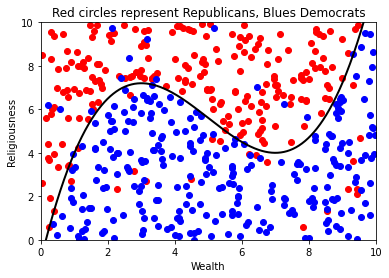

In [4]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)

### 2. Finding the optimal k - 15 points
Lets sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. We plot the train vs validation error for several k values, and choose the best k. WE want to know, where do we underfit/overfit the data? Finally, we will estimate the generalization error of the chosen classifier using the test set. What would happen if we optimize directly on test? is the optimal k the same?


In [6]:
import sklearn.metrics
from sklearn.model_selection import train_test_split

X, y = generate_data(1000) #Set the number to 2000 to produce more consistent results.

K with largest accuracy for validation set: 8 : 0.9566666666666667
The optimal k for this set is 8, the test_error (generalization error) is 0.91
K with optimal accuracy when optimizing the test set directly on the training is: 9 with accuracy of 0.92


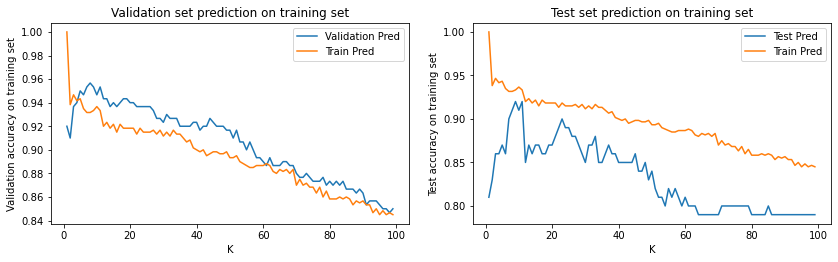

In [23]:
def pred_y(x_train, y_train, x_pred, n):
    knn = kNNClassifier(n)
    knn.fit(x_train, y_train)
    return knn.predict(x_pred)

def accuracy(y, pred_y):
    return sklearn.metrics.accuracy_score(y, pred_y)

# def F1(y, pred_y):
#     # TP = len(y[(y == 1) & (pred_y ==1)])
#     # TN = len(y[(y == 0) & (pred_y ==0)])
#     # FP = len(y[(y == 0) & (pred_y == 1)])
#     # FN = len(y[(y == 1) & (pred_y == 0)])

#     # recall = TP / (TP + FN)
#     # precision = TP / (TP + FP)
#     # acc = (TP + TN) / (TP + TN + FP + FN)
#     # F1 = (2*precision*recall) / (precision + recall)
    
#     return  sklearn.metrics.f1_score(y, pred_y)
#     # return F1

x_train, x_rem, y_train, y_rem = sklearn.model_selection.train_test_split(X, y, train_size= 0.6)
x_valid, x_test, y_valid, y_test = sklearn.model_selection.train_test_split(x_rem, y_rem)

k_vals = np.arange(1,100,1)
acc_vals = []
train_vals = []
test_vals = []

fig = plt.figure(figsize= (12,4))

for k in k_vals:
    pred_y_valid = pred_y(x_train, y_train, x_valid, k)
    valid_error = accuracy(y_valid, pred_y_valid)
    acc_vals.append(valid_error)

    pred_y_train = pred_y(x_train, y_train, x_train, k)
    train_error = accuracy(y_train, pred_y_train)
    train_vals.append(train_error)

plt.subplot(1,2,1)
plt.plot(k_vals, acc_vals)
plt.plot(k_vals, train_vals)
plt.legend(['Validation Pred', 'Train Pred'])
plt.ylabel('Validation accuracy on training set')
plt.xlabel('K')
plt.title('Validation set prediction on training set')

plt.tight_layout(pad = 2.0)

print(f'K with largest accuracy for validation set: {np.argmax(acc_vals)+1} : {np.max(acc_vals)}')

optimal_k = np.argmax(acc_vals)+1
#Now, calculate the error of the training set, using our newfound optimal K.

pred_y_test = pred_y(x_train, y_train, x_test, optimal_k)
test_error = accuracy(y_test, pred_y_test)
print(f"The optimal k for this set is {optimal_k}, the test_error (generalization error) is {test_error}")


#Now, we will try to optimize directly on the training set, and see if our optimal K value is any different.
k_vals = np.arange(1,100,1)
acc_vals = []
test_vals = []

for k in k_vals:
    pred_y_test = pred_y(x_train, y_train, x_test, k)
    valid_error = accuracy(y_test, pred_y_test)
    acc_vals.append(valid_error)

plt.subplot(1,2,2)
plt.plot(k_vals, acc_vals)
plt.plot(k_vals, train_vals)
plt.legend(['Test Pred', 'Train Pred'])
plt.ylabel('Test accuracy on training set')
plt.xlabel('K')
plt.title('Test set prediction on training set')
plt.tight_layout(pad = 2.0)

print(f'K with optimal accuracy when optimizing the test set directly on the training is: {np.argmax(acc_vals)+1} with accuracy of {np.max(acc_vals)}')
optimal_k = np.argmax(acc_vals)+1
# print(f"The optimal k for this set is {optimal_k}")


For both the validation set, we consistently see through numerous samplings that with lower values of k, overfitting of the data is produced. This is seen by the lower Accuracy scores for lower K's. For larger values of k (usually above 20 or 40, depending on the sampling), we start to see more underfitting and generalization of the data than necessary. 

When producing the optimal value of k for the validation set and the test set, there are differences in the values. However, the differences are usually not vast (with exceptions).

### 3. Using cross validation
This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.

K with largest average F1 across 5 folds: 4 : 0.9324999999999999


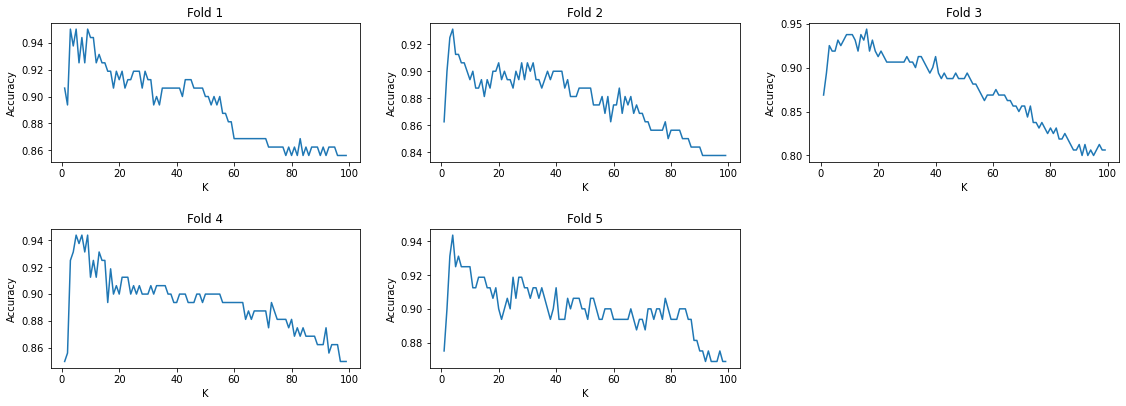

In [8]:
x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size= 0.8)
from sklearn.model_selection import KFold
plt.figure(figsize=(16, 6)) 

acc_min = []
acc_folds_error = []
k_vals = np.arange(1,100,1)
# x_train, x_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

kfold = KFold(5, shuffle= False)

fold = 0
for train, test in kfold.split(x_train):
    fold_train_x= x_train[train]
    fold_train_y= y_train[train]
    fold_test_x= x_train[test]
    fold_test_y= y_train[test]


    F1_errors = [] 
    acc_errors = []

    for k in k_vals:
        pred_y_valid = pred_y(fold_train_x, fold_train_y, fold_test_x, k)
        acc_error = accuracy(fold_test_y, pred_y_valid)
        acc_errors.append(acc_error)

    acc_folds_error.append(acc_errors)

    plt.subplot(2,3, fold+1)
    plt.plot(k_vals, acc_errors)
    plt.title(f'Fold {fold+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('K')

    fold +=1
plt.tight_layout(pad = 2.0)

avg_k_acc_error_perfold = np.average(np.array(acc_folds_error), axis = 0)

print(f'K with largest average F1 across 5 folds: {np.argmax(avg_k_acc_error_perfold) +1} : {np.max(avg_k_acc_error_perfold)}')



Checking to see that the naive Kfolds split came out with an accurate score using sklearn:

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(x_train, y_train)
knn_gscv.best_params_
# knn_gscv.best_score_

{'n_neighbors': 7}

(Looks like we get the same optimal k for both versions of the Kfolds.)

When splitting our data into training, validation, and test samples, we have reduced our total amount of samples in which we can train our model significantly. The advantage of the k-folds cross validation, is that we do not have to split our data in to three data sets, rather just two. Originally, our training data set was made up of 600 samples, and validation and test were 200 each. With k-folds, we are able to still validate our training set, while still retaining as many samples as possible to train on. Through each fold, we allocate a different section of our 800 samples to validate on, and then choose another section again for the next fold (and so on).

As we can see, we get a different optimization of k when we use Kfolds cross validation, as opposed to without it. The K recieved without Kfolds was different than with Kfolds, because the Kfolds validation reduces the overfitting to our training set, even more than a simple validation set does. This way provides a more accurate k, because the data is now a less biased or less optimistic estimate.

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html